In [4]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import random
import os

# Data Loading

In [13]:
dataset_name = 'letterboxd-200'

In [14]:
with open(f'dataset/{dataset_name}/{dataset_name}-network.jl') as f:
    records = [json.loads(line) for line in f]
network = pd.DataFrame.from_records(records)

In [15]:
with open(f'dataset/{dataset_name}/{dataset_name}-users.jl') as f:
    test_users = {json.loads(line).get('username') for line in f}

In [16]:
with open(f'dataset/{dataset_name}/{dataset_name}-ratings.jl') as f:
    records = [json.loads(line) for line in f]
ratings = pd.DataFrame.from_records(records).dropna(subset=['rating']) #.sort_values(by='updated_at')
del records
ratings['rating'] = ratings['rating'].astype(int)

# Dataset Reconfiguration

## Network Randomization

### Randomize core users

In [37]:
follows_list = network[network.username.isin(test_users)].groupby('username')['follows'].apply(list)
random_network_core = pd.DataFrame({ 'username': np.random.permutation(follows_list.index.values), 'follows': follows_list.values}).explode('follows')
network[~network.username.isin(test_users)].append(random_network_core).to_json(f'dataset/{dataset_name}/{dataset_name}-random-1-network.jl', orient='records', lines=True)

### Core users to 1-hop neighbourhood Randomization

In [38]:
core_and_hop_1_users = np.append(network[network.username.isin(test_users)].follows.unique(), list(test_users))
df = network[network.username.isin(test_users)].groupby('username').count().rename(columns={'follows': 'follows_count'})
df['follows'] = df.apply(lambda row: random.sample(core_and_hop_1_users.tolist(), row.follows_count), axis=1)
network[~network.username.isin(test_users)].append(df[['follows']].explode('follows').reset_index()).to_json(f'dataset/{dataset_name}/{dataset_name}-random-2-network.jl', orient='records', lines=True)

### Total Randomization

## Network Reduction

In [ ]:
reduction_rates = (0.2, 0.4, 0.6, 0.8, 0.95)

In [152]:
for reduction_rate in reduction_rates:
    core_and_hop_1_users = np.append(network[network.username.isin(test_users)].follows.unique(), list(test_users))
    reduced_network = network[network.username.isin(core_and_hop_1_users)].groupby('username').sample(frac=1 - reduction_rate)
    network[~network.username.isin(test_users)].append(reduced_network).to_json(f'dataset/{dataset_name}/{dataset_name}-reduced-{int(reduction_rate * 100)}-network.jl', orient='records', lines=True)

username      follows
137        fatiihturan    asliildir
138             ceysar    asliildir
139      elifsenaozefe    asliildir
140         vivaquilla    asliildir
141        42unicorn42    asliildir
...                ...          ...
5672        yusufbahap     akkayamr
5667        yusufbahap       zoogle
1399   zeynepnazciftci        tviil
13102       zeynepocak  utkuogeturk
1528            zoogle    upsibupsi

[7507 rows x 2 columns]

## Rating Reduction

In [ ]:
# apply only for the first train fold
with open(f'dataset/{dataset_name}/ratings-folds/train-0.jl') as f:
    records = [json.loads(line) for line in f]
ratings = pd.DataFrame.from_records(records).dropna(subset=['rating']) #.sort_values(by='updated_at')
del records
ratings['rating'] = ratings['rating'].astype(int)
for reduction_rate in reduction_rates:
    ratings.groupby('username').sample(frac=1 - reduction_rate).to_json(f'dataset/{dataset_name}/ratings-folds/train-reduced-{int(reduction_rate * 100)}-0.jl', orient='records', lines=True)

## Cold-start user generation

# Exploratory Data Analysis

In [2]:
import seaborn as sns

In [5]:
print([[255 * c for c in rgb] for rgb in sns.cubehelix_palette(start=0, rot=6, light=.7)])

[[215.19648045998974, 158.72741817146346, 189.01749188058884], [140.11978468849514, 165.09672221080285, 105.06325085450354], [86.43784545625749, 133.64825990337238, 156.51051937306661], [134.267387186231, 71.44742330247931, 105.14412835348632], [57.35762826058884, 77.19730723749078, 29.511525162957053], [22.25326688565813, 42.26353242949158, 58.07756204177098]]


In [4]:
sns.cubehelix_palette(start=0, rot=6, light=.7)

[[0.8439077665097637, 0.6224604634175037, 0.7412450661983876],
 [0.5494893517195888, 0.6474381263168739, 0.41201274844903346],
 [0.33897194296571564, 0.52411082315048, 0.613766742639477],
 [0.5265387732793372, 0.280185973735213, 0.4123299151117111],
 [0.22493187553172095, 0.30273453818623836, 0.11573147122728256],
 [0.08726771327709071, 0.16573934286075132, 0.22775514526184698]]

In [267]:
sns.color_palette('dark:salmon_r')

[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.8206223693544625, 0.42905134566038194, 0.3844558865578708),
 (0.6608525818461801, 0.35614190700703835, 0.3218529495863298),
 (0.5010827943378977, 0.2832324683536948, 0.25925001261478886),
 (0.3413130068296151, 0.21032302970035122, 0.19664707564324785),
 (0.18154321932133266, 0.1374135910470077, 0.13404413867170692)]

In [268]:
sns.set_palette(sns.color_palette('dark:salmon_r'))

In [275]:
all_users = np.unique(np.concatenate((network.username.unique(), network.follows.unique(), ratings.username.unique())))
max_1_hop_users = network[network.username.isin(test_users)].follows.unique()
non_core_1_hop_users = {u for u in max_1_hop_users if u not in test_users}
non_core_users = {u for u in all_users if u not in test_users}
os.makedirs('figures', exist_ok=True)

In [277]:
print(f'# Users: {len(all_users)}')
print(f'# Core users: {len(test_users)}')
print(f'# Non-core-1-hop users: {len(non_core_1_hop_users)}')
print(f'# Max-1-hop users: {len(max_1_hop_users)}')
print(f'# Non-core users: {len(non_core_users)}')

# Users: 28063
# Core users: 49
# Non-core-1-hop users: 2414
# Max-1-hop users: 2424
# Non-core users: 28014


In [52]:
network[network.username.isin(test_users)].groupby('username').count().describe().loc[('count', 'min', 'mean', 'max'),:]

follows
count   49.000000
min      1.000000
mean    57.265306
max    100.000000

In [49]:
network[network.username.isin(non_core_1_hop_users)].groupby('username').count().describe().loc[('count', 'min', 'mean', 'max'),:]

follows
count  2397.000000
min       1.000000
mean     22.612432
max      25.000000

In [50]:
ratings[ratings.username.isin(test_users)][['username', 'rating']].groupby('username').count().describe().loc[('min', 'mean', 'max'),:]

rating
min    21.000000
mean  145.590909
max   216.000000

In [271]:
ratings[ratings.username.isin(non_core_1_hop_users)][['username', 'rating']].groupby('username').count().describe().loc[('min', 'mean', 'max'),:]

rating
min    1.000000
mean  57.526684
max   72.000000

<AxesSubplot:xlabel='followees', ylabel='Count'>

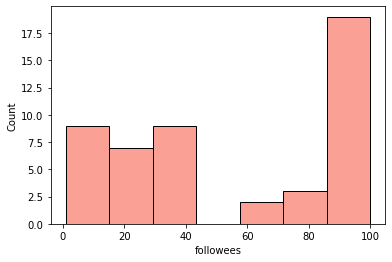

In [269]:
sns.histplot(network[network.username.isin(test_users)] \
             .groupby('username').count().rename(columns={'follows': 'followees'}), \
             x='followees')#.get_figure().savefig(f'figures/{dataset_name}-network-core-hist.png')

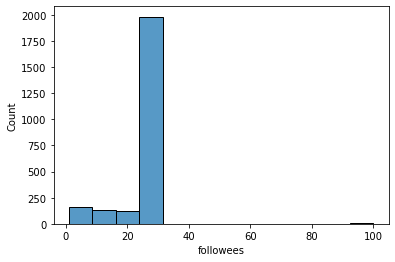

In [83]:
sns.histplot(network[network.username.isin(max_1_hop_users)] \
             .groupby('username').count().rename(columns={'follows': 'followees'}), \
             x='followees')#.get_figure().savefig(f'figures/{dataset_name}-network-max-1-hop-hist.png')

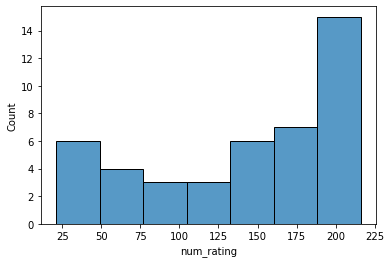

In [84]:
sns.histplot(ratings[ratings.username.isin(test_users)][['username', 'rating']] \
             .groupby('username').count().rename(columns={'rating': 'num_rating'}), \
             x='num_rating').get_figure().savefig(f'figures/{dataset_name}-ratings-core-hist.png')

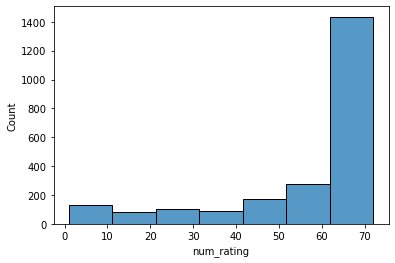

In [90]:
sns.histplot(ratings[ratings.username.isin(non_core_1_hop_users)][['username', 'rating']] \
             .groupby('username').count().rename(columns={'rating': 'num_rating'}), \
             x='num_rating', bins=7)#.get_figure().savefig(f'figures/{dataset_name}-ratings-non-core-1-hop-hist.png')